The assignment for this week has two main objectives: 1) to reinforce understanding and application of container technology; and 2) To run the containerized ML projects on AWS cloud using Amazon EC2.

1. This assignment uses the Wine Quality Dataset at the UCI repository:  https://archive.ics.uci.edu/ml/datasets/wine+quality. The model will predict the wine quality, which has a score between 0 and 10 from the 11 given features:

1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulfates
11 - alcohol  

Build the model for predicting the wine quality. Containerize the model post to Hub.docker.com and deploy it on Heroku (extra credit)

2. Start an EC2 virtual machine on AWS, install docker on EC2 then pull the container image from part 1 and run in EC2.

Instructions
1. For problem 1, submit the your notebook, Hub.docker.com user so that I can pull your model and test as well as the Heroku URL of your application (extra credit)

2. For problem 2, submit an image of a web page showing the IP address of an EC2 host with your project on the page.

If your solution (application) is not working properly, submit all error logs and describe the actions you took to troubleshoot the error.

## Libraries

In [22]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

## Data load

In [2]:
red = pd.read_csv("../jupyter/Data/winequality-red.csv", delimiter=';')
white = pd.read_csv("../jupyter/Data/winequality-red.csv", delimiter=';')

## Data Prep/Clean

In [3]:
# Add new column 'red' to combine the two dataframes
red['red'] = 1

In [4]:
# Add new column 'red' to combine the two dataframes
white['red'] = 0

In [5]:
# Merge two data frames #####################################################################  1   ###################
df = pd.concat([red,white], axis=0)
df = shuffle(df, random_state = 31337).reset_index().drop(columns = ['index'])

In [6]:
# Remove Spaces in Column Names                               #############################  2  #######################
df = df.rename(columns={'fixed acidity':'fixed_acidity'})
df = df.rename(columns={'volatile acidity':'volatile_acidity'})
df = df.rename(columns={'citric acid':'citric_acid'})
df = df.rename(columns={'residual sugar':'residual_sugar'})
df = df.rename(columns={'free sulfur dioxide':'free_sulfur_dioxide'})
df = df.rename(columns={'total sulfur dioxide':'total_sulfur_dioxide'})

## Exploration and Visualization

In [7]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,3198.0,8.32,1.74,4.60,7.10,7.90,9.20,15.90
volatile_acidity,3198.0,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric_acid,3198.0,0.27,0.19,0.00,0.09,0.26,0.42,1.00
residual_sugar,3198.0,2.54,1.41,0.90,1.90,2.20,2.60,15.50
chlorides,3198.0,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free_sulfur_dioxide,3198.0,15.87,10.46,1.00,7.00,14.00,21.00,72.00
total_sulfur_dioxide,3198.0,46.47,32.89,6.00,22.00,38.00,62.00,289.00
density,3198.0,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,3198.0,3.31,0.15,2.74,3.21,3.31,3.40,4.01
sulphates,3198.0,0.66,0.17,0.33,0.55,0.62,0.73,2.00


In [8]:
cor = df.corr().round(2)
cor.sort_values(['quality'],ascending=False,inplace=True)
cor.quality

quality                 1.00
alcohol                 0.48
sulphates               0.25
citric_acid             0.23
fixed_acidity           0.12
residual_sugar          0.01
red                     0.00
free_sulfur_dioxide    -0.05
pH                     -0.06
chlorides              -0.13
density                -0.17
total_sulfur_dioxide   -0.19
volatile_acidity       -0.39
Name: quality, dtype: float64

In [9]:
# Check Target Variable                                 #############################  3  #######################
df['quality'].unique()

array([7, 5, 6, 4, 3, 8])

In [10]:
# Explore 

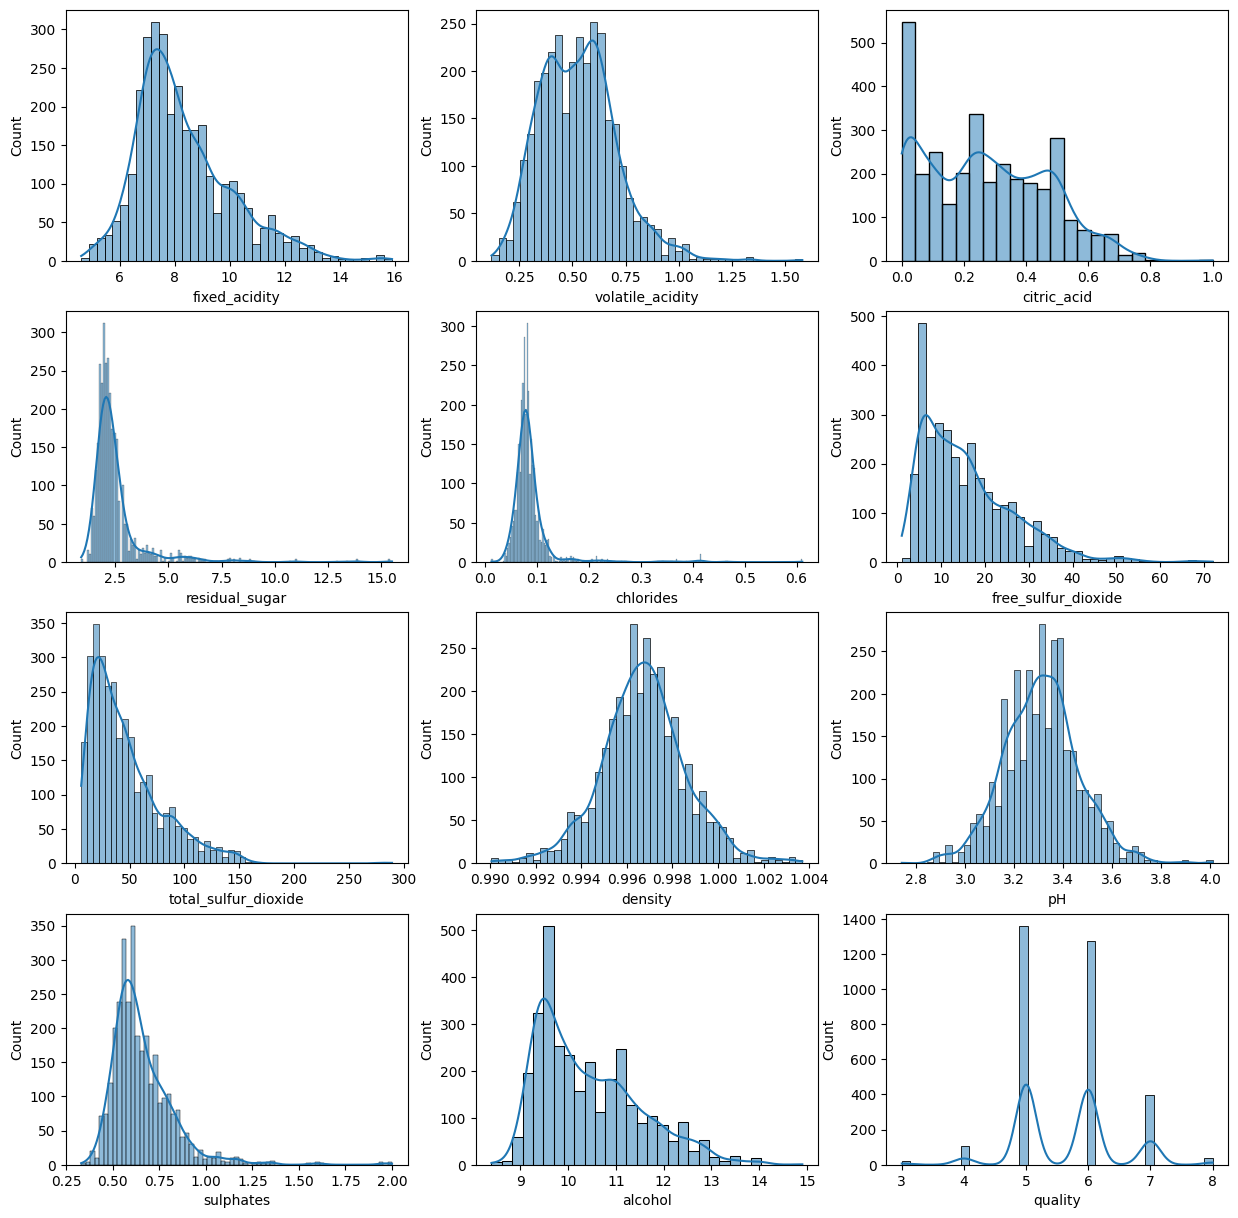

In [11]:
# select the columns to be plotted
cols = df.drop(columns=['red'])

# create the figure and axes
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(15, 15)  # ( x , y )
axes = axes.ravel()  # flattening the array makes indexing easier
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, ax = ax)

plt.show()

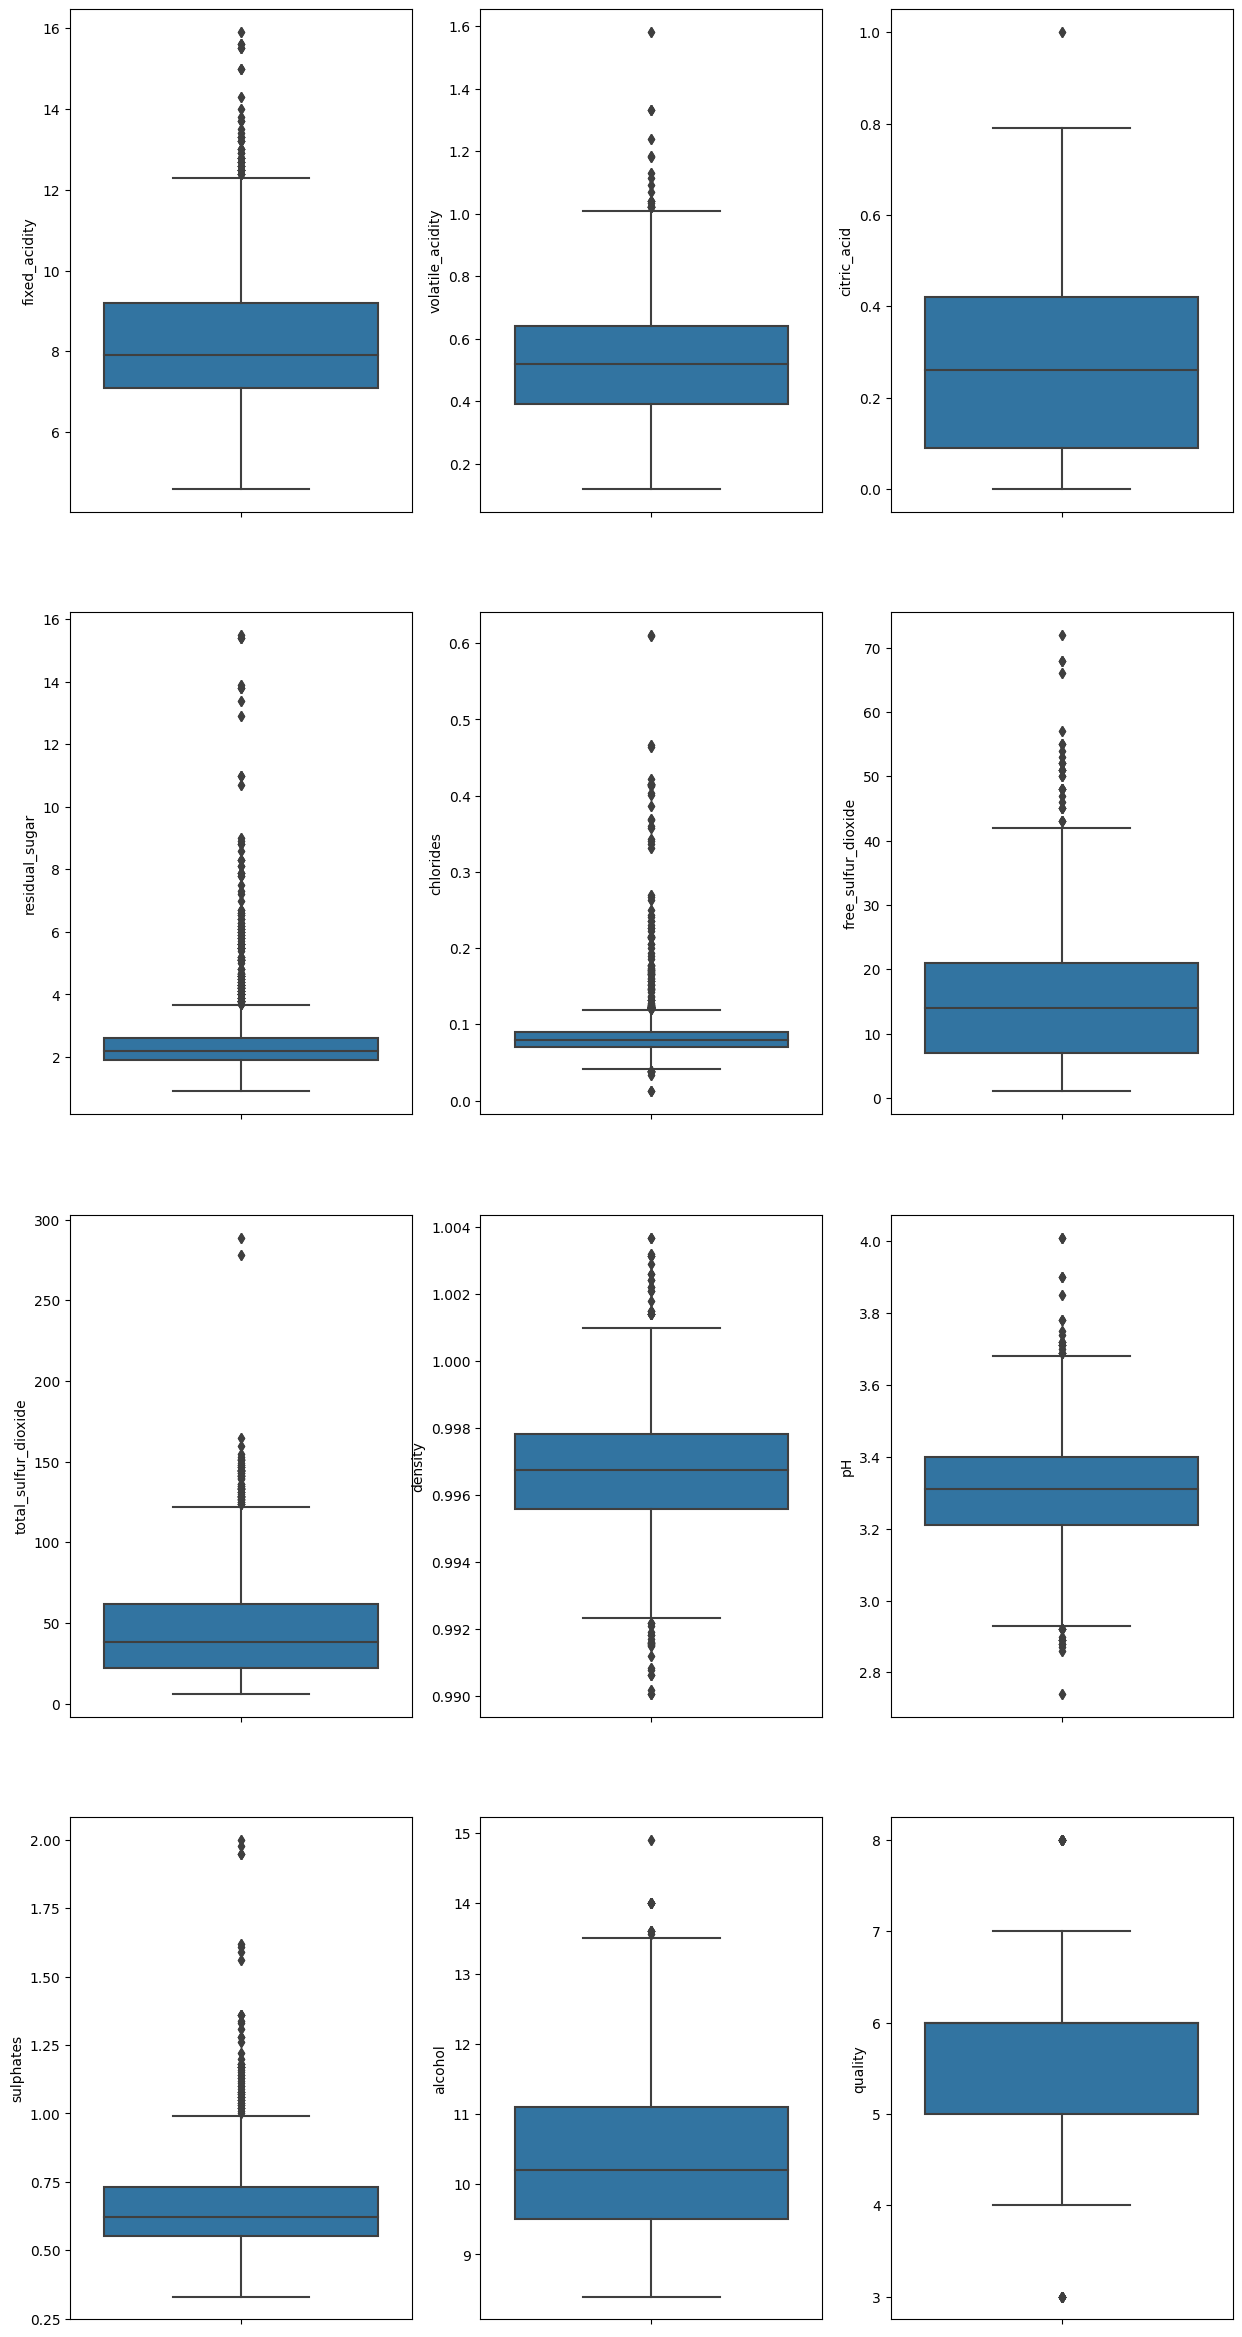

In [12]:
# create the figure and axes
fig, axes = plt.subplots(4, 3)
axes = axes.ravel()  # flattening the array makes indexing easier
fig.set_size_inches(15, 30)  # ( x , y )
for col, ax in zip(cols, axes):
    sns.boxplot(ax =ax,y=df[col])
plt.show()

## Data Transormation

**Outliers**

In [13]:
# Remove values outside +/- 1.5*IQR and replace with Column Mean         #################################  4  ####################
df_outliers = df.copy()

# Exclude Quality, as it's changing categorical to continuous
columns_to_iterate = [col for col in df_outliers.columns if col != 'quality']

for col in columns_to_iterate:
    # Calculate IQR
    q75, q25 = np.percentile(df_outliers[col], [75 ,25])
    IQR = q75 - q25

    # Calculate lower and upper bounds
    lower_bound = q25 - (IQR * 1.5)
    upper_bound = q75 + (IQR * 1.5)

    # Select rows that are outside the bounds
    outliers = df.query(f'{col} < {lower_bound} or {col} > {upper_bound}')
    
    # Replace values in column 'i' that are </> min/max with mean
    df_outliers[col] = np.where(df_outliers[col] > upper_bound, 
                              df_outliers[col].mean(), 
                              df_outliers[col])
    
    df_outliers[col] = np.where(df_outliers[col] < lower_bound, 
                              df_outliers[col].mean(), 
                              df_outliers[col])

In [15]:
# Quick View of Outlier transformation made
1 - df_outliers.describe().round(2).T/df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,0.0,0.018029,0.143678,0.000000,0.0,0.0,0.021739,0.226415
volatile_acidity,0.0,0.018868,0.055556,0.000000,0.0,0.0,0.015625,0.360759
citric_acid,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.210000
residual_sugar,0.0,0.129921,0.687943,0.000000,0.0,0.0,0.023077,0.764516
chlorides,0.0,0.111111,0.800000,-3.000000,0.0,0.0,0.000000,0.803279
free_sulfur_dioxide,0.0,0.042218,0.126195,0.000000,0.0,0.0,0.000000,0.416667
total_sulfur_dioxide,0.0,0.072090,0.186683,0.000000,0.0,0.0,0.064516,0.577855
density,0.0,0.000000,NaN,0.000000,0.0,0.0,0.000000,0.000000
pH,0.0,0.000000,0.066667,-0.069343,0.0,0.0,0.000000,0.082294
sulphates,0.0,0.030303,0.294118,0.000000,0.0,0.0,0.027397,0.505000


**Scale/Normalize**

In [16]:
# Import modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Move df_outliers to df
df_before_outlier = df.copy()
df = df_outliers.copy()

# Separate features and target variable
y = df['quality'].copy()
#X = df.drop('quality', axis=1) # all features
X = df[['alcohol','sulphates','citric_acid','volatile_acidity']] # Retain Correlated

# Get the list of names for numerical and categorical attributes separately
num_attributes = X.select_dtypes(exclude='object')

# Convert to list (mutable)
num_attribs = list(num_attributes)


# Numerical Pipeline to scale
pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Run the transformation pipeline
X = pipeline.fit_transform(X)

# # Min Max Scaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

numpy.ndarray

**Test/Train Split**

In [18]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=31337)

In [19]:
if isinstance(X_train, pd.DataFrame):
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
          .format(type(X_train),type(y_train),X_train.shape,y_train.shape,type(X_train),type(y_train)))
else:
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
        .format(X_train.dtype,y_train.dtype,X_train.shape,y_train.shape,type(X_train),type(y_train)))
       

DType:
X_train:float64, y_train:int64
Shape:
X_train:(2398, 4), y_train:(2398,)
Type:
X_train:<class 'numpy.ndarray'>, y_train<class 'pandas.core.series.Series'>


## Modeling

**Logistic Regression Multi-class**

In [20]:
# Model Original
lgreg = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

In [23]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        29
           5       0.66      0.77      0.71       341
           6       0.55      0.60      0.58       315
           7       0.54      0.31      0.39       100
           8       0.00      0.00      0.00        10

    accuracy                           0.60       800
   macro avg       0.29      0.28      0.28       800
weighted avg       0.57      0.60      0.58       800



In [26]:
print(cm)

[[  0   0   4   1   0   0]
 [  0   0  21   8   0   0]
 [  0   0 263  76   2   0]
 [  0   0 106 190  19   0]
 [  0   0   6  63  31   0]
 [  0   0   0   5   5   0]]


**KNN**

In [27]:
# Model Original Data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [28]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.27      0.14      0.18        29
           5       0.69      0.79      0.74       341
           6       0.66      0.65      0.66       315
           7       0.71      0.60      0.65       100
           8       1.00      0.10      0.18        10

    accuracy                           0.67       800
   macro avg       0.55      0.38      0.40       800
weighted avg       0.67      0.67      0.66       800



In [29]:
print(cm)

[[  0   0   4   1   0   0]
 [  2   4  14   8   1   0]
 [  0   6 268  65   2   0]
 [  0   4  85 206  20   0]
 [  0   1  16  23  60   0]
 [  0   0   0   7   2   1]]


**Linear SVM**

In [30]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)

In [31]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        29
           5       0.65      0.79      0.71       341
           6       0.53      0.64      0.58       315
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00        10

    accuracy                           0.59       800
   macro avg       0.20      0.24      0.22       800
weighted avg       0.48      0.59      0.53       800



In [32]:
print(cm)

[[  0   0   4   1   0   0]
 [  0   0  21   8   0   0]
 [  0   0 270  71   0   0]
 [  0   0 113 202   0   0]
 [  0   0   9  91   0   0]
 [  0   0   0  10   0   0]]


**SVM (RBF)**

In [33]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [34]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        29
           5       0.67      0.80      0.73       341
           6       0.58      0.62      0.60       315
           7       0.63      0.34      0.44       100
           8       0.00      0.00      0.00        10

    accuracy                           0.63       800
   macro avg       0.31      0.29      0.30       800
weighted avg       0.59      0.63      0.60       800



In [35]:
print(cm)

[[  0   0   4   1   0   0]
 [  0   0  20   9   0   0]
 [  0   0 274  66   1   0]
 [  0   0 104 196  15   0]
 [  0   0   6  60  34   0]
 [  0   0   0   6   4   0]]


**Naive Bayes**

In [36]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [37]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        29
           5       0.64      0.81      0.72       341
           6       0.55      0.46      0.50       315
           7       0.45      0.45      0.45       100
           8       0.00      0.00      0.00        10

    accuracy                           0.58       800
   macro avg       0.27      0.29      0.28       800
weighted avg       0.55      0.58      0.56       800



In [38]:
print(cm)

[[  0   0   5   0   0   0]
 [  0   0  21   8   0   0]
 [  0   0 277  60   4   0]
 [  0   2 120 146  47   0]
 [  0   0   9  46  45   0]
 [  0   0   0   5   5   0]]


**Decision Tree**    ## bestmodel

In [70]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

with open('wine_dt','wb') as file:
    pickle.dump(dt,file)

In [65]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.79      0.88        29
           2       0.92      0.92      0.92       341
           3       0.87      0.90      0.89       315
           4       0.86      0.86      0.86       100
           5       1.00      0.60      0.75        10

    accuracy                           0.90       800
   macro avg       0.94      0.78      0.84       800
weighted avg       0.90      0.90      0.90       800



In [41]:
print(cm)

[[  3   0   2   0   0   0]
 [  0  23   2   4   0   0]
 [  0   2 323  14   2   0]
 [  0   2  22 285   6   0]
 [  0   0   0  14  86   0]
 [  0   0   0   0   4   6]]


**Random Forest**

In [59]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [60]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.79      0.88        29
           2       0.92      0.95      0.93       341
           3       0.88      0.90      0.89       315
           4       0.91      0.86      0.89       100
           5       1.00      0.60      0.75        10

    accuracy                           0.91       800
   macro avg       0.95      0.78      0.85       800
weighted avg       0.91      0.91      0.91       800



In [61]:
print(cm)

[[  3   0   2   0   0   0]
 [  0  23   2   4   0   0]
 [  0   0 323  18   0   0]
 [  0   0  24 285   6   0]
 [  0   0   0  14  86   0]
 [  0   0   0   2   2   6]]


**XGBoost**

In [46]:
y_mapped = df['quality'].map({ 3:0, 4:1, 5:2, 6:3, 7:4, 8:5})
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y_mapped,random_state=31337)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [47]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.79      0.88        29
           2       0.91      0.94      0.92       341
           3       0.89      0.90      0.89       315
           4       0.90      0.88      0.89       100
           5       1.00      0.60      0.75        10

    accuracy                           0.90       800
   macro avg       0.95      0.78      0.85       800
weighted avg       0.90      0.90      0.90       800



In [48]:
print(cm)

[[  3   0   2   0   0   0]
 [  0  23   2   4   0   0]
 [  0   0 319  22   0   0]
 [  0   0  26 283   6   0]
 [  0   0   2  10  88   0]
 [  0   0   0   0   4   6]]
